##Preprocessing: Mel


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
import os,glob,skimage,librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")    
root="/content/drive/MyDrive/Thesis_Keras/"        
csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
examplePath = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/fold6/85249-2-0-79.wav'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import random
import keras
from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tqdm._tqdm import trange
from keras.utils import np_utils

def readFromCsv(csvpth):
    # 生成数据列表
    # 读取wav文件函数
    #data = pd.read_csv('metadata/UrbanSound8K.csv')
    data = pd.read_csv(csvpth)
    valid_data = data[['slice_file_name', 'fold', 'classID', 'class']][data['end'] - data['start'] >= 2]
    valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
        'str')
    return valid_data


def splitData(current):
  
  D=[]
  i=1

  for row in tqdm(current.itertuples(),total=current.shape[0]):
        #print(row.path)
        #print(row.classID)
        #print(f"{i} out of {len(current)}")
        X, sample_rate = librosa.load("/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/" + row.path, res_type='kaiser_fast', duration=2.97)


        mels = librosa.feature.melspectrogram(X, sr=sample_rate,n_mels=40,n_fft=256,
                         hop_length=1000)

        if mels.shape != (40, 128): 
          continue
        feature = mels
        label = row.classID
        D.append((feature,label))
  dataset = D
  X,y=zip(*dataset)
  
  print("type of X is:",type(X))
  y=np.array(y).astype(np.int64)
  y = np.array(np_utils.to_categorical(y, 10))

  return  X,y


def save_npy(nparr,modelName,featureName,subDataset,fold):
    import os
    dirs = "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy"+'/'+modelName+'/'+featureName+'/'+fold
    
    #Create a directory to place the dataset npy files.
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        print(f"Created directory:{dirs}")
    
    subDataset+='.npy'
    print(subDataset)
    subsetPth=os.path.join(dirs,subDataset)
    #with open(subsetPth, 'w') as f:
    np.save(subsetPth, nparr)
    print(f"save {subDataset} done")
    print(f"Path:{subsetPth}")

def Ten_fold():
    csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
    #df=pd.read_csv(csvPth)
    valid_data=readFromCsv(csvPth)
    #valid_data = df[['slice_file_name', 'fold', 'classID', 'class']][df['end'] - df['start']]
    # valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
    #     'str')
    for i in range(10):#Folder : "fold1" to "fold10"
        print(f"fold:{i+1} out of 10")
        current=valid_data[valid_data['fold'] == i+1]
        X,y = splitData(current)
        print("Dataset split done!")
        print("Saving subsets to .npy files!")
        
        save_npy(X, 'MelConv1', 'mel', 'X',f"fold{i+1}")
        save_npy(y, 'MelConv1', 'mel', 'y',f"fold{i+1}")

In [ ]:
Ten_fold() # generate 10-fold training and test data packed in .npy files. Easier to be used in later experiments.

In [ ]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
import os,glob,skimage,librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")  

Then we do 10-fold again...

Ten fold

In [ ]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
from tqdm import tqdm
def generate_loader(i_val):
    train_X = []
    train_y=[]
    X_test=[]
    y_test=[]
    for i in range(10):
        if i + 1 == i_val:
            X_test = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/X.npy"
                )
            y_test=np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/y.npy"
            )
        else:
            X_train = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/X.npy"
            )
            y_train = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/y.npy"
            )

            for item in X_train:
                train_X.append(item)
            for item in y_train:
                train_y.append(item)

    return np.array(train_X),np.array(train_y),np.array(X_test),np.array(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed,AveragePooling1D,AveragePooling2D
from tensorflow.keras.optimizers import Adam


def build_model(input_length):
  model = Sequential()
  model.add(Reshape((128,40,1), input_shape=(input_length,128)))
  model.add(Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
  model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Conv2D(16, kernel_size=10, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
  model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(10, activation='softmax', name='y_pred'))

  return model

def train_model(model,X_train,Y_train,X_test,Y_test,X_val,Y_val,foldNum):
  EPOCHS = 100
  # this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
  BATCH_SIZE = 32
  callbacks = []
  # model architecture
  
  # this controls the learning rate
  opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
  #callbacks.append(BatchLoggerCallback(BATCH_SIZE, train_sample_count, epochs=EPOCHS))

  # train the neural network
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2,validation_data=(X_val,Y_val),shuffle=True)
  print(model.summary())
  # Use this flag to disable per-channel quantization for a model.
  # This can reduce RAM usage for convolutional models, but may have
  # an impact on accuracy.
  disable_per_channel_quantization = False
  print("Result of fold:"+f"{foldNum}")
  score = model.evaluate(
        x=X_test,
        y=Y_test)

In [ ]:
for i in tqdm(range(10)):
  #from tensorflow.compat.v1.keras import backend as K
  import tensorflow as tf

  import os
  # os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
  # config = tf.compat.v1.ConfigProto()#对session进行参数配置
  # config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
  # config.gpu_options.per_process_gpu_memory_fraction=0.7#分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
  # config.gpu_options.allow_growth = True#按需分配显存，这个比较重要
        
  # sess = tf.compat.v1.Session(config=config)
  # #tf.compat.v1.keras.backend.set_session(sess)
  # #K.set_session(sess)
  x_train,y_train,X_test,y_test = generate_loader(i+1)
  #print(X_train[1])
  #print(y_train[1])
  from sklearn.model_selection import train_test_split

  X_train, X_val, Y_train, Y_val = train_test_split(x_train,y_train, test_size=0.2)
  input_len=len(X_train[0])
  print(X_train[0].shape)
  model = build_model(input_len)
  if not i==0:
    model = build_model(input_len)
  
  train_model(model,X_train,Y_train,X_test,y_test,X_val,Y_val,i+1)
  model.save("/content/drive/MyDrive/Thesis_Keras/"+"model/saved/Trivedi"+f"fold{i+1}"+".h5")

  0%|          | 0/10 [00:00<?, ?it/s]

(40, 128)
Epoch 1/100
169/169 - 2s - loss: 2.3121 - accuracy: 0.2493 - val_loss: 2.0423 - val_accuracy: 0.2848 - 2s/epoch - 13ms/step
Epoch 2/100
169/169 - 1s - loss: 1.9445 - accuracy: 0.3313 - val_loss: 1.9145 - val_accuracy: 0.2974 - 819ms/epoch - 5ms/step
Epoch 3/100
169/169 - 1s - loss: 1.7648 - accuracy: 0.3858 - val_loss: 1.8435 - val_accuracy: 0.3353 - 812ms/epoch - 5ms/step
Epoch 4/100
169/169 - 1s - loss: 1.6460 - accuracy: 0.4267 - val_loss: 1.6865 - val_accuracy: 0.4149 - 831ms/epoch - 5ms/step
Epoch 5/100
169/169 - 1s - loss: 1.5592 - accuracy: 0.4563 - val_loss: 1.7285 - val_accuracy: 0.4119 - 815ms/epoch - 5ms/step
Epoch 6/100
169/169 - 1s - loss: 1.5569 - accuracy: 0.4593 - val_loss: 1.6022 - val_accuracy: 0.4178 - 820ms/epoch - 5ms/step
Epoch 7/100
169/169 - 1s - loss: 1.4205 - accuracy: 0.4842 - val_loss: 1.4843 - val_accuracy: 0.4669 - 812ms/epoch - 5ms/step
Epoch 8/100
169/169 - 1s - loss: 1.3874 - accuracy: 0.5108 - val_loss: 1.4224 - val_accuracy: 0.4967 - 814ms/e

 10%|█         | 1/10 [01:24<12:42, 84.70s/it]

(40, 128)
Epoch 1/100
169/169 - 2s - loss: 2.3261 - accuracy: 0.2564 - val_loss: 2.1199 - val_accuracy: 0.2524 - 2s/epoch - 10ms/step
Epoch 2/100
169/169 - 1s - loss: 2.0197 - accuracy: 0.2997 - val_loss: 2.0399 - val_accuracy: 0.2687 - 819ms/epoch - 5ms/step
Epoch 3/100
169/169 - 1s - loss: 1.8659 - accuracy: 0.3511 - val_loss: 1.9733 - val_accuracy: 0.3675 - 827ms/epoch - 5ms/step
Epoch 4/100
169/169 - 1s - loss: 1.7976 - accuracy: 0.3782 - val_loss: 1.9851 - val_accuracy: 0.3623 - 817ms/epoch - 5ms/step
Epoch 5/100
169/169 - 1s - loss: 1.8054 - accuracy: 0.3680 - val_loss: 2.0677 - val_accuracy: 0.2962 - 822ms/epoch - 5ms/step
Epoch 6/100
169/169 - 1s - loss: 1.6953 - accuracy: 0.4072 - val_loss: 1.9449 - val_accuracy: 0.4031 - 824ms/epoch - 5ms/step
Epoch 7/100
169/169 - 1s - loss: 1.6455 - accuracy: 0.4278 - val_loss: 1.9120 - val_accuracy: 0.4499 - 826ms/epoch - 5ms/step
Epoch 8/100
169/169 - 1s - loss: 1.6071 - accuracy: 0.4551 - val_loss: 1.8161 - val_accuracy: 0.4566 - 815ms/e

 20%|██        | 2/10 [02:49<11:18, 84.75s/it]

(40, 128)
Epoch 1/100
167/167 - 2s - loss: 2.2116 - accuracy: 0.2769 - val_loss: 1.9854 - val_accuracy: 0.3256 - 2s/epoch - 10ms/step
Epoch 2/100
167/167 - 1s - loss: 1.8676 - accuracy: 0.3629 - val_loss: 1.7421 - val_accuracy: 0.3968 - 809ms/epoch - 5ms/step
Epoch 3/100
167/167 - 1s - loss: 1.6744 - accuracy: 0.4146 - val_loss: 1.6896 - val_accuracy: 0.4501 - 805ms/epoch - 5ms/step
Epoch 4/100
167/167 - 1s - loss: 1.6420 - accuracy: 0.4475 - val_loss: 1.7940 - val_accuracy: 0.3323 - 807ms/epoch - 5ms/step
Epoch 5/100
167/167 - 1s - loss: 1.5996 - accuracy: 0.4602 - val_loss: 1.9149 - val_accuracy: 0.4321 - 814ms/epoch - 5ms/step
Epoch 6/100
167/167 - 1s - loss: 1.4422 - accuracy: 0.5099 - val_loss: 1.7088 - val_accuracy: 0.4501 - 814ms/epoch - 5ms/step
Epoch 7/100
167/167 - 1s - loss: 1.3703 - accuracy: 0.5308 - val_loss: 1.6295 - val_accuracy: 0.5094 - 806ms/epoch - 5ms/step
Epoch 8/100
167/167 - 1s - loss: 1.3280 - accuracy: 0.5561 - val_loss: 1.6921 - val_accuracy: 0.4734 - 803ms/e

 30%|███       | 3/10 [04:13<09:49, 84.26s/it]

(40, 128)
Epoch 1/100
167/167 - 2s - loss: 2.2475 - accuracy: 0.2374 - val_loss: 2.0711 - val_accuracy: 0.2472 - 2s/epoch - 10ms/step
Epoch 2/100
167/167 - 1s - loss: 1.8746 - accuracy: 0.3549 - val_loss: 1.8459 - val_accuracy: 0.4012 - 812ms/epoch - 5ms/step
Epoch 3/100
167/167 - 1s - loss: 1.7001 - accuracy: 0.4147 - val_loss: 1.8372 - val_accuracy: 0.4125 - 804ms/epoch - 5ms/step
Epoch 4/100
167/167 - 1s - loss: 1.6169 - accuracy: 0.4506 - val_loss: 1.7282 - val_accuracy: 0.4305 - 809ms/epoch - 5ms/step
Epoch 5/100
167/167 - 1s - loss: 1.5023 - accuracy: 0.4694 - val_loss: 1.7752 - val_accuracy: 0.4523 - 808ms/epoch - 5ms/step
Epoch 6/100
167/167 - 1s - loss: 1.3907 - accuracy: 0.5167 - val_loss: 1.6723 - val_accuracy: 0.4598 - 805ms/epoch - 5ms/step
Epoch 7/100
167/167 - 1s - loss: 1.2736 - accuracy: 0.5494 - val_loss: 1.6317 - val_accuracy: 0.4906 - 808ms/epoch - 5ms/step
Epoch 8/100
167/167 - 1s - loss: 1.2575 - accuracy: 0.5481 - val_loss: 1.4111 - val_accuracy: 0.5770 - 832ms/e

 40%|████      | 4/10 [05:35<08:21, 83.54s/it]

(40, 128)
Epoch 1/100
168/168 - 2s - loss: 2.3421 - accuracy: 0.2315 - val_loss: 2.0540 - val_accuracy: 0.2212 - 2s/epoch - 10ms/step
Epoch 2/100
168/168 - 1s - loss: 1.9978 - accuracy: 0.2816 - val_loss: 1.9728 - val_accuracy: 0.2601 - 812ms/epoch - 5ms/step
Epoch 3/100
168/168 - 1s - loss: 1.8730 - accuracy: 0.3283 - val_loss: 1.9386 - val_accuracy: 0.3430 - 816ms/epoch - 5ms/step
Epoch 4/100
168/168 - 1s - loss: 1.7691 - accuracy: 0.3754 - val_loss: 1.8548 - val_accuracy: 0.3625 - 807ms/epoch - 5ms/step
Epoch 5/100
168/168 - 1s - loss: 1.7042 - accuracy: 0.4012 - val_loss: 1.7162 - val_accuracy: 0.4148 - 805ms/epoch - 5ms/step
Epoch 6/100
168/168 - 1s - loss: 1.7457 - accuracy: 0.3999 - val_loss: 1.8141 - val_accuracy: 0.3789 - 804ms/epoch - 5ms/step
Epoch 7/100
168/168 - 1s - loss: 1.6447 - accuracy: 0.4217 - val_loss: 1.7597 - val_accuracy: 0.4133 - 806ms/epoch - 5ms/step
Epoch 8/100
168/168 - 1s - loss: 1.5675 - accuracy: 0.4443 - val_loss: 1.9359 - val_accuracy: 0.3954 - 811ms/e

 50%|█████     | 5/10 [06:58<06:56, 83.37s/it]

(40, 128)
Epoch 1/100
170/170 - 2s - loss: 2.1714 - accuracy: 0.2991 - val_loss: 2.0871 - val_accuracy: 0.2893 - 2s/epoch - 10ms/step
Epoch 2/100
170/170 - 1s - loss: 1.9211 - accuracy: 0.3456 - val_loss: 1.9244 - val_accuracy: 0.3779 - 811ms/epoch - 5ms/step
Epoch 3/100
170/170 - 1s - loss: 1.7770 - accuracy: 0.3792 - val_loss: 1.7917 - val_accuracy: 0.4428 - 821ms/epoch - 5ms/step
Epoch 4/100
170/170 - 1s - loss: 1.6232 - accuracy: 0.4394 - val_loss: 1.7850 - val_accuracy: 0.4052 - 817ms/epoch - 5ms/step
Epoch 5/100
170/170 - 1s - loss: 1.6041 - accuracy: 0.4499 - val_loss: 1.7249 - val_accuracy: 0.4716 - 816ms/epoch - 5ms/step
Epoch 6/100
170/170 - 1s - loss: 1.5527 - accuracy: 0.4742 - val_loss: 1.6628 - val_accuracy: 0.4598 - 818ms/epoch - 5ms/step
Epoch 7/100
170/170 - 1s - loss: 1.4617 - accuracy: 0.4973 - val_loss: 1.6767 - val_accuracy: 0.4723 - 816ms/epoch - 5ms/step
Epoch 8/100
170/170 - 1s - loss: 1.4182 - accuracy: 0.5162 - val_loss: 1.5654 - val_accuracy: 0.5181 - 809ms/e

 60%|██████    | 6/10 [08:23<05:34, 83.73s/it]

(40, 128)
Epoch 1/100
169/169 - 2s - loss: 2.2508 - accuracy: 0.2480 - val_loss: 1.9870 - val_accuracy: 0.3195 - 2s/epoch - 10ms/step
Epoch 2/100
169/169 - 1s - loss: 1.9702 - accuracy: 0.3232 - val_loss: 1.9428 - val_accuracy: 0.3447 - 811ms/epoch - 5ms/step
Epoch 3/100
169/169 - 1s - loss: 1.8684 - accuracy: 0.3573 - val_loss: 1.9287 - val_accuracy: 0.3632 - 816ms/epoch - 5ms/step
Epoch 4/100
169/169 - 1s - loss: 1.7015 - accuracy: 0.4033 - val_loss: 1.8088 - val_accuracy: 0.4151 - 811ms/epoch - 5ms/step
Epoch 5/100
169/169 - 1s - loss: 1.5201 - accuracy: 0.4631 - val_loss: 1.7953 - val_accuracy: 0.3907 - 820ms/epoch - 5ms/step
Epoch 6/100
169/169 - 1s - loss: 1.3824 - accuracy: 0.5015 - val_loss: 1.4837 - val_accuracy: 0.5130 - 811ms/epoch - 5ms/step
Epoch 7/100
169/169 - 1s - loss: 1.3631 - accuracy: 0.5287 - val_loss: 1.4638 - val_accuracy: 0.5100 - 808ms/epoch - 5ms/step
Epoch 8/100
169/169 - 1s - loss: 1.2565 - accuracy: 0.5599 - val_loss: 1.3861 - val_accuracy: 0.5500 - 815ms/e

 70%|███████   | 7/10 [09:47<04:11, 83.79s/it]

(40, 128)
Epoch 1/100
170/170 - 2s - loss: 2.1589 - accuracy: 0.2845 - val_loss: 2.0750 - val_accuracy: 0.3091 - 2s/epoch - 10ms/step
Epoch 2/100
170/170 - 1s - loss: 1.9451 - accuracy: 0.3242 - val_loss: 1.9745 - val_accuracy: 0.2678 - 837ms/epoch - 5ms/step
Epoch 3/100
170/170 - 1s - loss: 1.7596 - accuracy: 0.3790 - val_loss: 1.8387 - val_accuracy: 0.3745 - 820ms/epoch - 5ms/step
Epoch 4/100
170/170 - 1s - loss: 1.7090 - accuracy: 0.4098 - val_loss: 1.8552 - val_accuracy: 0.3473 - 825ms/epoch - 5ms/step
Epoch 5/100
170/170 - 1s - loss: 1.5496 - accuracy: 0.4631 - val_loss: 1.7371 - val_accuracy: 0.4511 - 827ms/epoch - 5ms/step
Epoch 6/100
170/170 - 1s - loss: 1.6826 - accuracy: 0.4328 - val_loss: 1.9032 - val_accuracy: 0.3539 - 829ms/epoch - 5ms/step
Epoch 7/100
170/170 - 1s - loss: 1.5122 - accuracy: 0.4747 - val_loss: 1.8772 - val_accuracy: 0.4224 - 828ms/epoch - 5ms/step
Epoch 8/100
170/170 - 1s - loss: 1.4349 - accuracy: 0.4994 - val_loss: 1.9182 - val_accuracy: 0.4238 - 818ms/e

 80%|████████  | 8/10 [11:11<02:48, 84.11s/it]

(40, 128)
Epoch 1/100
170/170 - 2s - loss: 2.2429 - accuracy: 0.2722 - val_loss: 1.9959 - val_accuracy: 0.2467 - 2s/epoch - 10ms/step
Epoch 2/100
170/170 - 1s - loss: 1.8368 - accuracy: 0.3708 - val_loss: 1.8434 - val_accuracy: 0.3146 - 821ms/epoch - 5ms/step
Epoch 3/100
170/170 - 1s - loss: 1.7922 - accuracy: 0.3914 - val_loss: 1.7476 - val_accuracy: 0.4476 - 820ms/epoch - 5ms/step
Epoch 4/100
170/170 - 1s - loss: 1.6138 - accuracy: 0.4429 - val_loss: 1.7796 - val_accuracy: 0.3693 - 816ms/epoch - 5ms/step
Epoch 5/100
170/170 - 1s - loss: 1.5399 - accuracy: 0.4743 - val_loss: 1.6701 - val_accuracy: 0.4734 - 835ms/epoch - 5ms/step
Epoch 6/100
170/170 - 1s - loss: 1.5034 - accuracy: 0.4751 - val_loss: 1.6307 - val_accuracy: 0.4269 - 824ms/epoch - 5ms/step
Epoch 7/100
170/170 - 1s - loss: 1.3760 - accuracy: 0.5205 - val_loss: 1.5515 - val_accuracy: 0.5096 - 814ms/epoch - 5ms/step
Epoch 8/100
170/170 - 1s - loss: 1.3672 - accuracy: 0.5231 - val_loss: 1.4860 - val_accuracy: 0.5244 - 814ms/e

 90%|█████████ | 9/10 [13:35<01:42, 102.72s/it]

(40, 128)
Epoch 1/100
169/169 - 2s - loss: 2.2667 - accuracy: 0.2648 - val_loss: 2.1395 - val_accuracy: 0.2528 - 2s/epoch - 10ms/step
Epoch 2/100
169/169 - 1s - loss: 1.9245 - accuracy: 0.3373 - val_loss: 1.9952 - val_accuracy: 0.3503 - 754ms/epoch - 4ms/step
Epoch 3/100
169/169 - 1s - loss: 1.8102 - accuracy: 0.3643 - val_loss: 1.9574 - val_accuracy: 0.2956 - 759ms/epoch - 4ms/step
Epoch 4/100
169/169 - 1s - loss: 1.7172 - accuracy: 0.3896 - val_loss: 1.9478 - val_accuracy: 0.2927 - 762ms/epoch - 5ms/step
Epoch 5/100
169/169 - 1s - loss: 1.6786 - accuracy: 0.3957 - val_loss: 1.9007 - val_accuracy: 0.3392 - 758ms/epoch - 4ms/step
Epoch 6/100
169/169 - 1s - loss: 1.6534 - accuracy: 0.4109 - val_loss: 1.8019 - val_accuracy: 0.4228 - 759ms/epoch - 4ms/step
Epoch 7/100
169/169 - 1s - loss: 1.5869 - accuracy: 0.4392 - val_loss: 1.6321 - val_accuracy: 0.4412 - 756ms/epoch - 4ms/step
Epoch 8/100
169/169 - 1s - loss: 1.5532 - accuracy: 0.4602 - val_loss: 1.5916 - val_accuracy: 0.4693 - 753ms/e

100%|██████████| 10/10 [14:53<00:00, 89.33s/it]


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Convolution2D, Activation, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed,LeakyReLU,SpatialDropout2D,GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam,SGD
# from tensorflow.keras import regularizers
# EPOCHS = 100
# # this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
# BATCH_SIZE = 32
# input_length=len(X_train[0])
# callbacks = []

In [ ]:
# def getModel():
#   model = Sequential()
#   input_shape = (40,128,1)
#   model.add(Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
#   model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
#   model.add(BatchNormalization())
#   #model.add(Dropout(0.5))
#   model.add(Conv2D(16, kernel_size=10, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
#   model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
#   model.add(Dropout(0.2))
#   model.add(Flatten())
#   model.add(Dense(10, activation='softmax', name='y_pred'))
#   return model

# # this controls the learning rate



    

In [ ]:
# opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# #sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
# optimizer=opt
# model=getModel()

# # train the neural network

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val,Y_val), verbose=2, callbacks=callbacks)
# print(model.summary())
# # Use this flag to disable per-channel quantization for a model.
# # This can reduce RAM usage for convolutional models, but may have
# # an impact on accuracy.
# disable_per_channel_quantization = False

Epoch 1/100
169/169 - 2s - loss: 2.2584 - accuracy: 0.2749 - val_loss: 2.0392 - val_accuracy: 0.2437 - 2s/epoch - 9ms/step
Epoch 2/100
169/169 - 1s - loss: 1.8167 - accuracy: 0.3496 - val_loss: 2.0764 - val_accuracy: 0.2922 - 744ms/epoch - 4ms/step
Epoch 3/100
169/169 - 1s - loss: 1.7208 - accuracy: 0.3970 - val_loss: 1.8055 - val_accuracy: 0.3790 - 752ms/epoch - 4ms/step
Epoch 4/100
169/169 - 1s - loss: 1.5838 - accuracy: 0.4354 - val_loss: 1.7570 - val_accuracy: 0.3940 - 750ms/epoch - 4ms/step
Epoch 5/100
169/169 - 1s - loss: 1.5174 - accuracy: 0.4622 - val_loss: 1.8724 - val_accuracy: 0.4007 - 750ms/epoch - 4ms/step
Epoch 6/100
169/169 - 1s - loss: 1.4605 - accuracy: 0.4774 - val_loss: 1.6394 - val_accuracy: 0.4274 - 751ms/epoch - 4ms/step
Epoch 7/100
169/169 - 1s - loss: 1.4059 - accuracy: 0.5010 - val_loss: 1.6763 - val_accuracy: 0.4307 - 751ms/epoch - 4ms/step
Epoch 8/100
169/169 - 1s - loss: 1.3594 - accuracy: 0.5211 - val_loss: 1.7346 - val_accuracy: 0.4457 - 752ms/epoch - 4ms/

In [ ]:
# # Save the model to disk
# model.save('/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/saved_models/spectro')

In [ ]:
# score = model.evaluate(
#         x=X_test,
#         y=Y_test)

47/47 [==============================] - 0s 3ms/step - loss: 1.8684 - accuracy: 0.6918


模型名称： TrivediCNN

准确度： 0.6918

In [ ]:
# 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


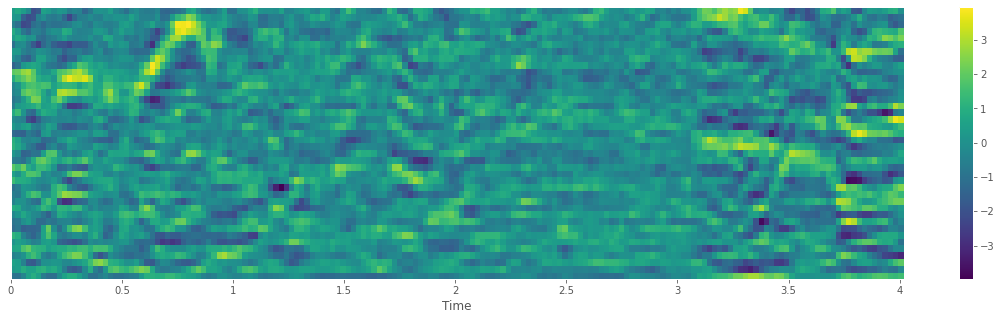

[1.0000001  1.0000001  1.         1.         1.0000001  1.0000001
 1.         0.99999994 1.0000001  1.         0.9999998  1.
 1.         0.99999994 1.         1.         0.99999994 1.
 1.         1.0000001  1.0000001  0.99999994 0.99999994 1.
 1.0000001  1.0000001  1.0000001  1.0000001  1.         1.0000001
 1.0000001  1.         1.         0.9999998  0.99999994 0.9999998
 1.         1.         1.         0.99999994]
[-1.1025136e-08  0.0000000e+00  6.8907102e-09  2.7562841e-09
  0.0000000e+00  2.2050273e-08  5.5125682e-09  1.1025136e-08
 -4.1344261e-09  5.5125682e-09 -1.3781420e-09  0.0000000e+00
 -1.1025136e-08  1.1025136e-08 -1.1025136e-08 -2.2050273e-08
 -5.5125682e-09 -2.7562841e-09  1.1025136e-08  1.1025136e-08
  0.0000000e+00 -5.5125682e-09 -5.5125682e-09  0.0000000e+00
 -1.1025136e-08 -1.1025136e-08  0.0000000e+00 -2.2050273e-08
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -5.5125682e-09
 -4.1344261e-09  1.1025136e-08 -5.5125682e-09 -5.5125682e-09
  7.5797812e-09 -8.2688523e-09

In [ ]:
# mfccs = extract_feature(examplePath)
# plt.figure(figsize=(20,5))
# librosa.display.specshow(mfccs, sr=22050, x_axis='time', cmap='viridis')
# plt.colorbar()
# plt.show()
# print (mfccs.var(axis=1))
# print (mfccs.mean(axis=1))


In [ ]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# pd.plotting.register_matplotlib_converters()
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
# from tensorflow.keras.utils import to_categorical 
# import os,glob,skimage,librosa
# import librosa.display

# import warnings
# warnings.filterwarnings("ignore")    
# root="/content/drive/MyDrive/Thesis_Keras/"         #忽略警告信息
# csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
# examplePath = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/fold6/85249-2-0-79.wav'

In [ ]:
# df = pd.read_csv(csvPth)

# df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# D=[]
# for i in range(8732):
#   try:
#     file_name = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
#     class_id = df["classID"][i]

#     X, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=2.97)
#     # print(f"{i}out of 8732")
#     # if i == 4803 or i==6246:
#     #   continue
#     # x = np.pad(X,(0,88200-X.shape[0]) if (0,88200-X.shape[0]>0) else (0,-88200+X.shape[0]),'constant')
#     # print(f"{i}out of 8732")

#     mels = librosa.feature.melspectrogram(X, sr=sample_rate,n_mels=40)
#     print('shape: ',mels.shape)
#     if mels.shape != (40, 128): 
#       continue
#     print(f"{i}out of 8732")
#     print('shape: ',mels.shape)
    
#     feature = mels
#     label = class_id
#     D.append((feature,label)) 
#   except Exception:
#     print("Error encountered while parsing file: ", file_name)
#     mfccs,class_id = None, None
  


流式输出内容被截断，只能显示最后 5000 行内容。
6943out of 8732
shape:  (40, 128)
shape:  (40, 128)
6944out of 8732
shape:  (40, 128)
shape:  (40, 128)
6945out of 8732
shape:  (40, 128)
shape:  (40, 128)
6946out of 8732
shape:  (40, 128)
shape:  (40, 128)
6947out of 8732
shape:  (40, 128)
shape:  (40, 128)
6948out of 8732
shape:  (40, 128)
shape:  (40, 128)
6949out of 8732
shape:  (40, 128)
shape:  (40, 128)
6950out of 8732
shape:  (40, 128)
shape:  (40, 128)
6951out of 8732
shape:  (40, 128)
shape:  (40, 128)
6952out of 8732
shape:  (40, 128)
shape:  (40, 128)
6953out of 8732
shape:  (40, 128)
shape:  (40, 128)
6954out of 8732
shape:  (40, 128)
shape:  (40, 128)
6955out of 8732
shape:  (40, 128)
shape:  (40, 128)
6956out of 8732
shape:  (40, 128)
shape:  (40, 128)
6957out of 8732
shape:  (40, 128)
shape:  (40, 128)
6958out of 8732
shape:  (40, 128)
shape:  (40, 128)
6959out of 8732
shape:  (40, 128)
shape:  (40, 110)
shape:  (40, 118)
shape:  (40, 128)
6962out of 8732
shape:  (40, 128)
shape:  (40, 128)
6

In [ ]:
# print(len(X))

7478


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import tensorflow as tf

# X_train = np.array([x.reshape((40, 128, 1)) for x in x_train])
# X_test = np.array([x.reshape((40, 128, 1)) for x in x_test])

# Y_train = np.array(tf.keras.utils.to_categorical(y_train, 10))
# Y_test = np.array(tf.keras.utils.to_categorical(y_test, 10))



In [ ]:
# X,Y=zip(*D)
# x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size = 0.2, random_state = 114514)


In [ ]:
# import os
# import librosa
# import pandas as pd
# import numpy as np
# import random
# import keras
# from scipy import signal
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from tqdm._tqdm import trange
# from keras.utils import np_utils

# def readFromCsv(csvpth):
#     # 生成数据列表
#     # 读取wav文件函数
#     #data = pd.read_csv('metadata/UrbanSound8K.csv')
#     data = pd.read_csv(csvpth)
#     valid_data = data[['slice_file_name', 'fold', 'classID', 'class']]
#     valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
#         'str')
#     return valid_data


# def splitData(current):
  
#   D=[]
#   csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
#   #df=pd.read_csv(csvPth)
#   #valid_data=readFromCsv(csvPth)
#   i=1

#   for row in tqdm(current.itertuples(),total=current.shape[0]):
#         #print(row.path)
#         #print(row.classID)
#         #print(f"{i} out of {len(current)}")
#         X, sample_rate = librosa.load("/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/" + row.path, res_type='kaiser_fast', duration=2.97)
#         # print(f"{i}out of 8732")
#         # if i == 4803 or i==6246:
#         #   continue
#         # x = np.pad(X,(0,88200-X.shape[0]) if (0,88200-X.shape[0]>0) else (0,-88200+X.shape[0]),'constant')
#         # print(f"{i}out of 8732")

#         mels = librosa.feature.melspectrogram(X, sr=sample_rate,n_mels=40)
#         #print('shape: ',mels.shape)
#         if mels.shape != (40, 128): 
#           continue
#         #print(f"{i}out of 8732")
#         #print('shape: ',mels.shape)
#         i+=1
#         D.append((mels, row.classID))
#   dataset = D
#   X,y=zip(*dataset)
  
#   print("type of X is:",type(X))
#   y=np.array(y).astype(np.int64)
#   y = np.array(np_utils.to_categorical(y, 10))

#   return  X,y


# def save_npy(nparr,modelName,featureName,subDataset,fold):
#     import os
#     dirs = "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy"+'/'+modelName+'/'+featureName+'/'+fold
    
#     #Create a directory to place the dataset npy files.
#     if not os.path.exists(dirs):
#         os.makedirs(dirs)
#         print(f"Created directory:{dirs}")
    
#     subDataset+='.npy'
#     print(subDataset)
#     subsetPth=os.path.join(dirs,subDataset)
#     #with open(subsetPth, 'w') as f:
#     np.save(subsetPth, nparr)
#     print(f"save {subDataset} done")
#     print(f"Path:{subsetPth}")

In [ ]:
# def Ten_fold():
#     csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
#     #df=pd.read_csv(csvPth)
#     valid_data=readFromCsv(csvPth)
#     #valid_data = df[['slice_file_name', 'fold', 'classID', 'class']][df['end'] - df['start']]
#     # valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
#     #     'str')
#     for i in range(10):#Folder : "fold1" to "fold10"
#         print(f"fold:{i+1} out of 10")
#         current=valid_data[valid_data['fold'] == i+1]
#         X,y = splitData(current)
#         print("Dataset split done!")
#         print("Saving subsets to .npy files!")
        
#         save_npy(X, 'Trivedi', 'mel40x128', 'X',f"fold{i+1}")
#         save_npy(y, 'Trivedi', 'mel40x128', 'y',f"fold{i+1}")

In [ ]:
# Ten_fold()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


fold:1 out of 10


 95%|█████████▌| 833/873 [06:04<00:14,  2.83it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
 96%|█████████▌| 835/873 [06:05<00:12,  3.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
 96%|█████████▌| 836/873 [06:05<00:12,  3.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
100%|██████████| 873/873 [06:19<00:00,  2.30it/s]


type of X is: <class 'tuple'>
Dataset split done!
Saving subsets to .npy files!
Created directory:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold1
X.npy
save X.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold1/X.npy
y.npy
save y.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold1/y.npy
fold:2 out of 10


100%|██████████| 888/888 [06:12<00:00,  2.38it/s]


type of X is: <class 'tuple'>
Dataset split done!
Saving subsets to .npy files!
Created directory:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold2
X.npy
save X.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold2/X.npy
y.npy
save y.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold2/y.npy
fold:3 out of 10


100%|██████████| 925/925 [06:19<00:00,  2.44it/s]


type of X is: <class 'tuple'>
Dataset split done!
Saving subsets to .npy files!
Created directory:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold3
X.npy
save X.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold3/X.npy
y.npy
save y.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold3/y.npy
fold:4 out of 10


100%|██████████| 990/990 [07:07<00:00,  2.31it/s]


type of X is: <class 'tuple'>
Dataset split done!
Saving subsets to .npy files!
Created directory:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold4
X.npy
save X.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold4/X.npy
y.npy
save y.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold4/y.npy
fold:5 out of 10


100%|██████████| 936/936 [06:42<00:00,  2.33it/s]


type of X is: <class 'tuple'>
Dataset split done!
Saving subsets to .npy files!
Created directory:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold5
X.npy
save X.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold5/X.npy
y.npy
save y.npy done
Path:drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/Trivedi/mel40x128/fold5/y.npy
fold:6 out of 10


 70%|███████   | 580/823 [03:47<01:35,  2.54it/s]


KeyboardInterrupt: ignored

In [ ]:
# def save_npy(nparr,folder,featureName,subDataset):
#     import os
#     dirs = root+folder+"/data/datasetnpy"+'/'+featureName
    
#     #Create a directory to place the dataset npy files.
#     if not os.path.exists(dirs):
#         os.makedirs(dirs)
#         print(f"Created directory:{dirs}")
    
#     subDataset+='.npy'
#     print(subDataset)
#     subsetPth=os.path.join(dirs,subDataset)
#     #with open(subsetPth, 'w') as f:
#     np.save(subsetPth, nparr)
#     print(f"save {subDataset} done")
#     print(f"Path:{subsetPth}")

In [ ]:

# folderName="TrivediCNN"

# save_npy(X_train, folderName, 'melspectro','x_train')
# save_npy(X_test, folderName, 'melspectro','x_test')
# save_npy(Y_train, folderName, 'melspectro','y_train')
# save_npy(Y_test, folderName, 'melspectro', 'y_test')

Created directory:/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro
x_train.npy
save x_train.npy done
Path:/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/x_train.npy
x_test.npy
save x_test.npy done
Path:/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/x_test.npy
y_train.npy
save y_train.npy done
Path:/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/y_train.npy
y_test.npy
save y_test.npy done
Path:/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/y_test.npy


In [ ]:
# import sys, os, random
# import tensorflow as tf
# X = np.load('/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/x_train.npy')
# Y = np.load('/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/y_train.npy')

# x_train, x_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=1)
# input_length = x_train[0].shape[0]


In [ ]:
# x_test=np.load('/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/x_test.npy',allow_pickle=True)
# Y_test = np.load('/content/drive/MyDrive/Thesis_Keras/TrivediCNN/data/datasetnpy/melspectro/y_test.npy')

# # X_train = np.array([tf.image.resize(x, [60,41]) for x in x_train])
# # X_test = np.array([tf.image.resize(x,[60,41]) for x in x_test])
# # X_val = np.array([tf.image.resize(x,[60,41]) for x in x_val])

# X_train = x_train
# X_test = x_test
# X_val = x_val
# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

(5383, 40, 128, 1)
(1496, 40, 128, 1)
(599, 40, 128, 1)
